In [1]:
import cv2
import numpy as np
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

cmap = mpl.colormaps['tab10']
colors = cmap(np.linspace(0, 1, 10))
markers = ["s","^",">","o","*"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fig_size = (6,3)
print(device)

cpu


Figure saved to output/Fig1_1.pdf


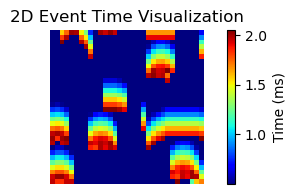

tensor([4.2000, 0.0000])


In [2]:
# Load data from npz file
from utils.visualizer import plot_event_time2d

data = np.load(f'./data/test_block{1}.npz')
temp = data['event_block']
evts = torch.Tensor(temp[np.argsort(temp[:, 2])]).to(device)
evts = evts[:600]
true_v = torch.Tensor(data['true_velocity'].flatten()).to(device)

plot_event_time2d(evts, output_file="output/Fig1_1.pdf")
print(true_v)

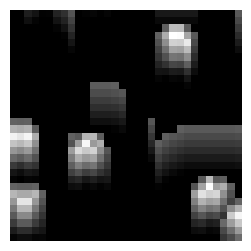

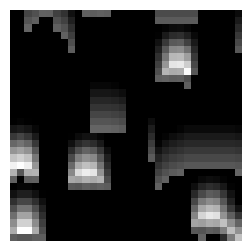

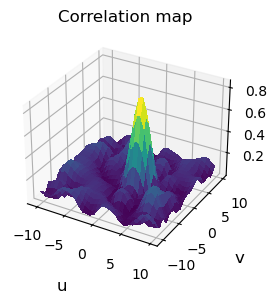

In [3]:
# Test the VG-CC method
from kernels.correlation import _events_to_voxel_grid

# To voxel grids
imgs, dt = _events_to_voxel_grid(evts, num_bins=2, H=32, W=32, t0=None, t1=None)
img1, img2 = imgs[0], imgs[1]
dt = dt.cpu().detach().numpy()

# perform cross correlation
imgs = imgs - torch.mean(imgs, dim=(1,2),keepdim=True)
imgs = imgs/(torch.norm(imgs,dim=(1,2),keepdim=True)+1e-9)
ffts = torch.fft.fft2(imgs)
R = torch.conj(ffts[:-1])*ffts[1:]
R = torch.mean(R,dim=0) # Ensemble for the I[0]*I[1],I[1]*I[2],I[2]*I[3]...
r = torch.fft.ifft2(R)
r = torch.roll(r, shifts=(16, 16), dims=(-2, -1))
r = r.abs()


# show the results
img1, img2 = img1.cpu().detach().numpy(), img2.cpu().detach().numpy()
for k, img in enumerate([img1,img2]):
    plt.figure(figsize=fig_size)
    plt.imshow(np.transpose(img), cmap="gray")
    plt.axis("off")
    plt.savefig(f"output/Fig1_{2+k}.pdf")

r = r.cpu().detach().numpy()
H, W = r.shape
vx = np.linspace(0,H-1,H)-H//2
vy = np.linspace(0,W-1,W)-W//2
vx, vy = vx/dt, vy/dt
vx,vy = np.meshgrid(vx,vy,indexing="ij")

fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(vy, vx, r, cmap=cm.viridis,
                       linewidth=0, antialiased=False,
                       rstride=1, cstride=1, alpha=1.0)
ax.set_xlabel('u', fontsize=12, labelpad=10)
ax.set_ylabel('v', fontsize=12, labelpad=10)
ax.grid(True, linestyle='--', alpha=0.3)
plt.savefig(f"output/Fig1_5.pdf")
plt.title("Correlation map")
plt.show()

torch.Size([32, 32])


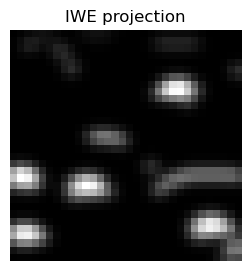

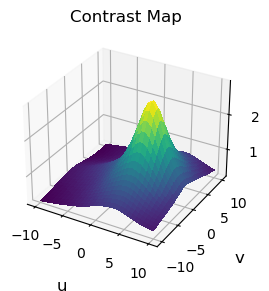

In [4]:
# Test the CMax method
def iwe_var(evts, v0, K, sigma2):
    # device = evts.device
    
    x, y, t, p = evts[:, 0], evts[:, 1], evts[:, 2], evts[:, 3]
    vx, vy = v0[:, 0], v0[:,1]

    t = t-torch.mean(t)
    
    x0, y0 = x - vx * t, y - vy * t  # (N,)
    
    px = torch.linspace(torch.min(x0).item(), torch.max(x0).item(), K, device=evts.device)
    py = torch.linspace(torch.min(y0).item(), torch.max(y0).item(), K, device=evts.device)
    px_g, py_g = torch.meshgrid(px, py, indexing='xy')

    exponent = torch.exp(-0.5*(torch.square(px_g[:,:,None] - x0[None,None,:])
                           +torch.square(py_g[:,:,None] - y0[None,None,:]))/sigma2)
    iwe = torch.mean(exponent,dim=-1)/(2*torch.pi*sigma2)
    iwe_mean = torch.mean(iwe)
    var = torch.mean(torch.square(iwe-iwe_mean)) # The negative variance of IWE image
    return var, iwe

def grid_var():
    vx = np.linspace(-10,10,32)
    vy = np.linspace(-10,10,32)
    vx, vy = np.meshgrid(vx,vy,indexing='ij')
    loss = np.zeros((32,32))
    for i in range(32):
        for j in range(32):
            v0 = torch.Tensor([[vx[i,j],vy[i,j]]]).to(device)
            var, iwe = iwe_var(evts, v0, 32, 1.0)
            loss[j,i] = var.item()
    return vx,vy, loss


# one velocity
v0 = torch.Tensor([[4.2,0.0]]).to(device)
var, iwe = iwe_var(evts, v0, 32, 1.0)
print(iwe.shape)

# grid velocity
vx,vy,loss = grid_var() 

iwe = iwe.cpu().detach().numpy()
plt.figure(figsize=fig_size)
plt.imshow(np.transpose(iwe), cmap="gray")
plt.axis("off")
plt.savefig(f"output/Fig1_6.pdf")
plt.title("IWE projection")

fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(vy, vx, loss, cmap=cm.viridis,
                       linewidth=0, antialiased=False,
                       rstride=1, cstride=1, alpha=1.0)
ax.set_xlabel('u', fontsize=12, labelpad=10)
ax.set_ylabel('v', fontsize=12, labelpad=10)
ax.grid(True, linestyle='--', alpha=0.3)
plt.savefig(f"output/Fig1_7.pdf")
plt.title("Contrast Map")

plt.show()

torch.Size([256, 256])


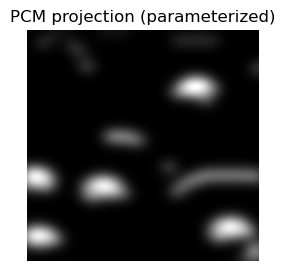

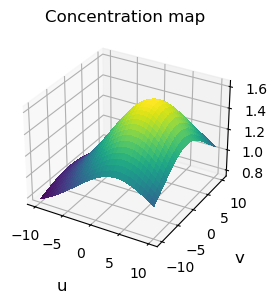

In [5]:
# PCM method
from kernels.pcm import objective2d_smooth


def grid_pcm():
    vx = np.linspace(-10,10,32)
    vy = np.linspace(-10,10,32)
    vx, vy = np.meshgrid(vx,vy,indexing='ij')
    loss = np.zeros((32,32))
    for i in range(32):
        for j in range(32):
            v0 = torch.Tensor([[vx[i,j],vy[i,j]]]).to(device)
            var, _, _ = objective2d_smooth(evts, v0, sigma2=1.0, tau2=25.0, compute_grad=False, compute_hessian=False)
            loss[j,i] = var.item()*len(evts)
    return vx,vy, loss


# grid velocity
vx,vy,loss = grid_pcm() 

v0 = torch.Tensor([[4.2,0.0]]).to(device)
var, iwe = iwe_var(evts, v0, 256, 1.0)
print(iwe.shape)
iwe = iwe.cpu().detach().numpy()
plt.figure(figsize=fig_size)
plt.imshow(np.transpose(iwe), cmap="gray")
plt.axis("off")
plt.savefig(f"output/Fig1_8.pdf")
plt.title("PCM projection (parameterized)")

fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(vy, vx, loss, cmap=cm.viridis,
                       linewidth=0, antialiased=False,
                       rstride=1, cstride=1, alpha=1.0)
ax.set_xlabel('u', fontsize=12, labelpad=10)
ax.set_ylabel('v', fontsize=12, labelpad=10)
# ax.set_zticks([])
ax.grid(True, linestyle='--', alpha=0.3)
plt.savefig(f"output/Fig1_9.pdf")
plt.title("Concentration map")


plt.show()